 ## Imports and Parameters

In [1]:
import itertools
import random

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import librosa

import IPython
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D,Dense,MaxPool2D, Flatten,Lambda
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
import tensorflow_addons as tfa

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Parameters
data_scaled = True
n_seconds = 3
sample_freq = 16000 #LibriSpeech dataset was originaly sampled at 16kHz
downsampling = 2
n_mfcc = 30
mfcc_hop = 512

batch_size = 124
filters = 64
embedding_dimension = 1500
dropout_rate = 0.2

num_training_iter = 4000
evaluate_every_n_batches = 25
num_evaluation_tasks = 100 # how many one-shot tasks to validate on
n_shot = 1
k_way = 4  # how many classes for testing n-shot tasks

new_sample_freq = int(sample_freq / downsampling)
original_fragment_len = int(n_seconds * sample_freq)

input_length_raw = int(new_sample_freq * n_seconds)

# Training/Testing data location
#training_set = 'train-clean-100'
training_set = 'sample'
test_set = 'dev-clean'
#test_set = 'sample-test'

## Get the Data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
'''
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1XhQyzCQKwe6FH30tGdXVScGM45ZHJ--A',
                                    dest_path='./Data_samples.zip',
                                    unzip=False)
file_name = 'Data_samples.zip'

if downsampling == 2:
  gdd.download_file_from_google_drive(file_id='1GtYPhEdnfDWaGAqYHkR_oC9TD05bn8yb',
                                    dest_path='./Data_pairs.zip',
                                    unzip=False)
  file_name_2 = 'Data_pairs.zip'
elif downsampling == 4:
  gdd.download_file_from_google_drive(file_id='1ND29zxpHdoUjNY8k_mHtIuGLwwOadBSz',
                                    dest_path='./Data_pairs_4khz.zip',
                                    unzip=False)
  file_name_2 = 'Data_pairs_4khz.zip'
'''

"\nfrom google_drive_downloader import GoogleDriveDownloader as gdd\n\ngdd.download_file_from_google_drive(file_id='1XhQyzCQKwe6FH30tGdXVScGM45ZHJ--A',\n                                    dest_path='./Data_samples.zip',\n                                    unzip=False)\nfile_name = 'Data_samples.zip'\n\nif downsampling == 2:\n  gdd.download_file_from_google_drive(file_id='1GtYPhEdnfDWaGAqYHkR_oC9TD05bn8yb',\n                                    dest_path='./Data_pairs.zip',\n                                    unzip=False)\n  file_name_2 = 'Data_pairs.zip'\nelif downsampling == 4:\n  gdd.download_file_from_google_drive(file_id='1ND29zxpHdoUjNY8k_mHtIuGLwwOadBSz',\n                                    dest_path='./Data_pairs_4khz.zip',\n                                    unzip=False)\n  file_name_2 = 'Data_pairs_4khz.zip'\n"

In [4]:
!ls

drive  sample_data


In [5]:
! unzip -q -o '/content/drive/My Drive/DLAS/Data_pairs_vggish.zip' -d /content/
! ls

drive		      test_diff_pairs.npy    X_test.npy   y_train.npy
sample_data	      train_alike_pairs.npy  X_train.npy
test_alike_pairs.npy  train_diff_pairs.npy   y_test.npy


In [6]:
! unzip -q -o '/content/drive/My Drive/DLAS/Data_samples.zip' -d /content/
! ls

Data	     test_alike_pairs.npy   train_diff_pairs.npy  y_test.npy
drive	     test_diff_pairs.npy    X_test.npy		  y_train.npy
sample_data  train_alike_pairs.npy  X_train.npy


## Load Pre-process Data

In [0]:
# Load data from .npy files
train_alike_pairs = np.load('train_alike_pairs.npy')
train_diff_pairs = np.load('train_diff_pairs.npy')
test_alike_pairs = np.load('test_alike_pairs.npy')
test_diff_pairs = np.load('test_diff_pairs.npy')

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

#### Train set

In [8]:
# Get the data
train_tree = pd.read_csv('./Data/LibriSpeech/train/tree-'+ training_set +'.txt', 
                      names=['ID_reader', 'ID_chapter', 'Audio_file'],
                      sep='/',
                      header=None)
IPython.display.display(train_tree)

# Info of the dataset
n_readers = train_tree['ID_reader'].nunique()
print(f'Number of Readers: {n_readers}')

n_chapters = train_tree['ID_chapter'].nunique()
print(f'Number of Chapters: {n_chapters}')

min_chapters_reader = min(train_tree['ID_reader'].value_counts())
print(f'Min number of audio files in one reader: {min_chapters_reader}')

max_chapters_reader = max(train_tree['ID_reader'].value_counts())
print(f'Max number of audio files in one reader: {max_chapters_reader}')

Labels_ID_reader_train = list(train_tree['ID_reader'].unique())
print(f'Number of labels: {len(Labels_ID_reader_train)}')

,ID_reader,ID_chapter,Audio_file
0,103,1240,103-1240-0000.flac
1,103,1240,103-1240-0001.flac
2,103,1240,103-1240-0002.flac
3,103,1240,103-1240-0003.flac
4,103,1240,103-1240-0004.flac
...,...,...,...
9065,911,130578,911-130578-0016.flac
9066,911,130578,911-130578-0017.flac
9067,911,130578,911-130578-0018.flac
9068,911,130578,911-130578-0019.flac


Number of Readers: 80
Number of Chapters: 182
Min number of audio files in one reader: 60
Max number of audio files in one reader: 166
Number of labels: 80


In [9]:
# Listen to a file of train dataset
file_audio = './Data/LibriSpeech/train/'+ training_set +'/19/227/19-227-0015.flac'
y, sr = librosa.load(file_audio, sr=new_sample_freq)
IPython.display.Audio(data=y, rate=sr)

In [10]:
print(X_train.shape)
print(y_train.shape)

(33346, 21, 128, 1)
(33346,)


In [0]:
if data_scaled == False:
  n_min = X_train.min()
  n_max = X_train.max()
  print(f'n_min {n_min}')
  print(f'n_max {n_max}')
  X_train = (X_train-n_min)/(n_max-n_min)
  X_train.shape

#### Test set

In [12]:
# Get the data
test_tree = pd.read_csv('./Data/LibriSpeech/val/tree-'+ test_set +'.txt', 
                      names=['ID_reader', 'ID_chapter', 'Audio_file'],
                      sep='/',
                      header=None)
IPython.display.display(test_tree)

# Info of the dataset
n_readers = test_tree['ID_reader'].nunique()
print(f'Number of Readers: {n_readers}')

n_chapters = test_tree['ID_chapter'].nunique()
print(f'Number of Chapters: {n_chapters}')

min_chapters_reader = min(test_tree['ID_reader'].value_counts())
print(f'Min number of audio files in one reader: {min_chapters_reader}')

max_chapters_reader = max(test_tree['ID_reader'].value_counts())
print(f'Max number of audio files in one reader: {max_chapters_reader}')

Labels_ID_reader_test = list(test_tree['ID_reader'].unique())
print(f'Number of labels: {len(Labels_ID_reader_test)}')

,ID_reader,ID_chapter,Audio_file
0,1272,128104,1272-128104-0000.flac
1,1272,128104,1272-128104-0001.flac
2,1272,128104,1272-128104-0002.flac
3,1272,128104,1272-128104-0003.flac
4,1272,128104,1272-128104-0004.flac
...,...,...,...
2698,8842,304647,8842-304647-0009.flac
2699,8842,304647,8842-304647-0010.flac
2700,8842,304647,8842-304647-0011.flac
2701,8842,304647,8842-304647-0012.flac


Number of Readers: 40
Number of Chapters: 97
Min number of audio files in one reader: 36
Max number of audio files in one reader: 101
Number of labels: 40


In [13]:
# Listen to a file of test dataset
file_audio = './Data/LibriSpeech/val/'+ test_set +'/1673/143396/1673-143396-0005.flac'
y, sr = librosa.load(file_audio, sr=new_sample_freq)
IPython.display.Audio(data=y, rate=sr)

In [14]:
print(X_test.shape)
print(y_test.shape)

(5067, 21, 128, 1)
(5067,)


In [0]:
if data_scaled == False:
  n_min_t = X_test.min()
  n_max_t = X_test.max()
  print(f'n_min {n_min_t}')
  print(f'n_max {n_max_t}')
  X_test = (X_test-n_min_t)/(n_max_t-n_min_t)
  X_test.shape

## Data Shapes and Labels


In [16]:
# Number of audios per speaker on training set
df_counts_y = pd.DataFrame(y_train)
print('Training Set\n')
print('ID   || nº audios')
df_counts_y[0].value_counts()

Training Set

ID   || nº audios


696     458
87      456
196     454
226     454
250     453
       ... 
458     307
1034    284
1040    278
445     196
1183    162
Name: 0, Length: 80, dtype: int64

In [17]:
# Train Targets
labels_train = np.unique(y_train)
print(labels_train.shape)
labels_train

(80,)


array([  19,   26,   27,   32,   39,   40,   60,   78,   83,   87,   89,
        103,  118,  125,  150,  163,  196,  198,  200,  201,  211,  226,
        229,  233,  248,  250,  254,  289,  298,  302,  307,  311,  322,
        328,  332,  374,  403,  405,  412,  426,  441,  445,  446,  458,
        460,  481,  587,  625,  669,  696,  730,  831,  839,  887,  909,
        911, 1034, 1040, 1069, 1081, 1088, 1098, 1116, 1183, 1235, 1246,
       1263, 1334, 1355, 1363, 1447, 1455, 1502, 1553, 1578, 1594, 1624,
       1723, 1737, 1743])

In [18]:
# Number of audios per speaker on test_set
df_counts_y = pd.DataFrame(y_test)
print('Testing Set\n')
print('ID   || nº audios')
df_counts_y[0].value_counts()

Testing Set

ID   || nº audios


422     147
1673    142
2902    138
3576    138
3000    138
3170    137
2803    137
5338    134
6319    134
5536    134
652     134
3536    133
2078    132
174     132
1993    132
8842    131
2086    131
2412    129
3853    129
8297    126
7976    125
6295    125
1919    125
7850    125
2035    123
84      123
1988    122
6241    121
5694    121
1272    121
251     121
6345    120
777     119
2428    117
5895    116
3081    114
2277    114
1462    113
6313    111
3752    103
Name: 0, dtype: int64

In [19]:
# Test Targets
labels = np.unique(y_test)
print(labels.shape)
labels

(40,)


array([  84,  174,  251,  422,  652,  777, 1272, 1462, 1673, 1919, 1988,
       1993, 2035, 2078, 2086, 2277, 2412, 2428, 2803, 2902, 3000, 3081,
       3170, 3536, 3576, 3752, 3853, 5338, 5536, 5694, 5895, 6241, 6295,
       6313, 6319, 6345, 7850, 7976, 8297, 8842])

In [20]:
print(X_train.shape)
print(y_train.shape)

(33346, 21, 128, 1)
(33346,)


In [21]:
print(X_test.shape)
print(y_test.shape)

(5067, 21, 128, 1)
(5067,)


In [22]:
print(f'Train Alike Pairs shape: {train_alike_pairs.shape}')
print(f'Train Diff Pairs shape: {train_diff_pairs.shape}')

Train Alike Pairs shape: (7061574, 2)
Train Diff Pairs shape: (7062132, 2)


In [23]:
print(f'Test Alike Pairs shape: {test_alike_pairs.shape}')
print(f'Test Diff Pairs shape: {test_diff_pairs.shape}')

Test Alike Pairs shape: (320122, 2)
Test Diff Pairs shape: (321126, 2)


## Siamese Model


In [0]:
def get_siamese_model(input_shape, filters, dropout_rate, embedding_dimension):
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    
    # 1 Block
    model.add(Conv2D(filters, (3, 3), 
                     activation='relu', 
                     padding='same',
                     input_shape=input_shape,
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters, (3, 3), 
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(SpatialDropout2D(dropout_rate))
    
    # 2 Block
    model.add(Conv2D(filters*2, (3, 3), 
                     activation='relu', 
                     padding='same',
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*2, (3, 3), 
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(SpatialDropout2D(dropout_rate))
    
    # 3 Block
    model.add(Conv2D(filters*3, (3, 3), 
                     activation='relu', 
                     padding='same',
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*3, (3, 3), 
                     activation='relu',
                     padding='same', 
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(SpatialDropout2D(dropout_rate))
    
    # 4 Block
    model.add(Conv2D(filters*4, (3, 3), 
                     activation='relu', 
                     padding='same',
                     kernel_initializer=he_normal(),
                     bias_initializer=he_normal(), 
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Conv2D(filters*4, (3, 3), 
                     activation='relu', 
                     padding='same',
                     kernel_initializer=he_normal(),
                     bias_initializer=he_normal(), 
                     kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    #model.add(Dropout(dropout_rate))
    model.add(SpatialDropout2D(dropout_rate))
    
    # Dense Block
    model.add(GlobalMaxPool2D())
    #model.add(Flatten())
    model.add(Dense(embedding_dimension, 
                    activation='sigmoid',
                    kernel_regularizer=l2()))
    model.add(Dropout(dropout_rate))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return siamese_net

In [28]:
model = get_siamese_model((X_train.shape[1], X_train.shape[2], 1),filters, dropout_rate, embedding_dimension)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21, 128, 1)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 21, 128, 1)] 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1500)         2235676     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1500)         0           sequential_1[1][0]         

In [0]:
radam = tfa.optimizers.RectifiedAdam()
biCrossentropy = BinaryCrossentropy(label_smoothing=0.1)
model.compile(optimizer=radam,
              loss=biCrossentropy,
              metrics=['accuracy'])

## Aux. Functions


In [0]:
def get_batch(X, y, alike_pairs, diff_pairs, batch_size):
  '''
  Create Batch of n pairs, half alike class, half different class
  '''
  left_array = []  #[batch_size, 24000, 1]
  right_array = []   #[batch_size, 24000, 1]
  targets = []  #[batch_size, 1]
    

  # Select random samples of alike pairs
  alike_pairs_selected = random.sample(list(train_alike_pairs),k=(batch_size//2))
  for pair in alike_pairs_selected:
    left = pair[0]
    left = X[left]
    left_array.append(left)
    right = pair[1]
    right = X[right]
    right_array.append(right)

  # Select random samples of diff pairs
  diff_pairs_selected = random.sample(list(train_diff_pairs),k=(batch_size//2))
  for pair in diff_pairs_selected:
    left = pair[0]
    left = X[left]
    left_array.append(left)
    right = pair[1]
    right = X[right]
    right_array.append(right)

  # array to numpy
  left_array = np.array(left_array)
  right_array = np.array(right_array)

  # Targets
  targets.extend(np.ones(batch_size//2)) #1 for alike pairs
  targets.extend(np.zeros(batch_size//2)) #0 for diff pairs
  targets = np.array(targets)
  targets = targets[:, np.newaxis]

  #print(f'left_array: {left_array.shape}')
  #print(f'right_array: {right_array.shape}')
  #print(f'targets: {targets.shape}')

  return [left_array, right_array], targets

In [31]:
# Example of function get_batch for training process
inputs_example, targets_example = get_batch(X_train, y_train, train_alike_pairs, train_diff_pairs, batch_size)
inputs_example = np.array(inputs_example)
print(f'inputs_example shape {inputs_example.shape}')
print(f'targets_example shape {targets_example.shape}')

inputs_example shape (2, 124, 21, 128, 1)
targets_example shape (124, 1)


In [0]:
# Testing the model by one-shot task
def get_oneshot_pairs(X, y, n_shot, k_way, model, alike_pairs, diff_pairs, num_ev_tasks):
  if n_shot == 1:
    selected_labels_test = random.choices(list(labels), k=num_ev_tasks)
    left_array = []  #[num_evaluation_tasks*k_way, 24000, 1]
    right_array = []   #[num_evaluation_tasks*k_way, 24000, 1]
    targets = []  #[num_evaluation_tasks*k_way, 1]

    for label in selected_labels_test:
      # get indexes of y_test with same label
      index_y_same_label = [index for index in range(len(y)) if y[index]==label]
      # get alike pair
      test_sample = random.sample(index_y_same_label, k=2)
      '''
      test_sample = random.choice(index_yTest_same_label)
      alike_pairs_to_select = [list(pair) for pair in alike_pairs if pair[0]==test_sample]
      # prevent from empty lists
      while not alike_pairs_to_select:
        test_sample = random.choice(index_yTest_same_label)
        alike_pairs_to_select = [list(pair) for pair in alike_pairs if pair[0]==test_sample]
      selected_alike_pair = random.choice(alike_pairs_to_select)
      '''
      left = test_sample[0]
      right_alike = test_sample[1]
      # insert into output arrays
      left = X[left]
      left_array.append(left)
      right_alike = X[right_alike]
      right_array.append(right_alike)
      targets.append(1)

      # get k_way-1 samples from the others classes
      remain_labels = [label_aux for label_aux in labels if label_aux!=label]
      remain_labels = random.sample(remain_labels,k=(k_way-1))
      for x in remain_labels:
        y_remain_labels = [index for index in range(len(y)) if y[index]==x]
        selected_diff_samples = random.choice(y_remain_labels)
        #insert test sample on left array
        left_array.append(left)
        #insert diff sample on right array
        right_alike = X[selected_diff_samples]
        right_array.append(right_alike)
        targets.append(0)

    # array to numpy
    left_array = np.array(left_array)
    right_array = np.array(right_array)
    targets = np.array(targets)
    targets = targets[:, np.newaxis]

    #print(f'left_array: {left_array.shape}')
    #print(f'right_array: {right_array.shape}')
    #print(f'targets: {targets.shape}')

  elif n_shot > 1:
    # To Do
    print('Not Implemented Yet')
  return [left_array, right_array], targets

def test_oneshot(X, y, n_shot, k_way, model, alike_pairs, diff_pairs, num_ev_tasks):
  n_correct_random = 0
  n_correct = 0
  inputs, targets = get_oneshot_pairs(X, y, n_shot, k_way, model, alike_pairs, diff_pairs, num_ev_tasks)
  probs = model.predict(inputs)
  probs = np.array(probs)
  for j in range(targets.shape[0]//k_way):
    arr_probs = np.array(probs[j*k_way:(j+1)*k_way,:])
    arr_targ = np.array(targets[j*k_way:(j+1)*k_way,:])
    idx_target = np.argmax(arr_targ)
    if np.argmax(arr_probs) == idx_target:
      n_correct += 1
    if random.randint(0,k_way) == idx_target:
      n_correct_random += 1

  test_acc = (n_correct)/(num_ev_tasks)
  random_test_acc = (n_correct_random)/(num_ev_tasks)

  return test_acc, random_test_acc

In [33]:
# Example of function test_oneshot for testing process
test_acc, random_test_acc = test_oneshot(X_test, y_test, n_shot, k_way, model, test_alike_pairs, test_diff_pairs, num_evaluation_tasks)
print(test_acc, random_test_acc)

0.29 0.17


## Training Pipeline

In [34]:
# Training the model
losses = []
train_accuracies = []
test_accuracies = []
random_test_accuraccies = []
best = -1

print("Starting training process!")
for i in range(1, num_training_iter+1):
  [left_array, right_array], targets = get_batch(X_train, y_train, train_alike_pairs, train_diff_pairs, batch_size)
  inputs = [left_array, right_array]
  #print(f'inputs: {np.array(inputs).shape}')
  #print(f'targets: {targets.shape}')
  loss, train_acc = model.train_on_batch(inputs, targets)
  losses.append(loss)
  train_accuracies.append(train_acc)

  if i % evaluate_every_n_batches == 0:
    print('\n----------------------------------')
    print(f'Iteration number {i}')
    print(f'Training Loss {loss}')
    print(f'Training Accuracy {train_acc}')
    #Test n shot
    test_acc, random_test_acc = test_oneshot(X_test, y_test, n_shot, k_way, model, test_alike_pairs, test_diff_pairs, num_evaluation_tasks)
    test_accuracies.append(test_acc)
    random_test_accuraccies.append(random_test_acc)
    print(f'Test Accuracy {test_acc}')
    if test_acc > best:
      print(f'Current best accuracy: {test_acc}')
      print('Saving model...')
      #model.save('./saved_models/best_model', overwrite=True, include_optimizer=False)
      model.save('/content/drive/My Drive/DLAS/best_model', overwrite=True, include_optimizer=False)
      best = test_acc
    print('----------------------------------\n')

Starting training process!

----------------------------------
Iteration number 25
Training Loss 20.873111724853516
Training Accuracy 0.5161290168762207
Test Accuracy 0.23
Current best accuracy: 0.23
Saving model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/DLAS/best_model/assets
----------------------------------


----------------------------------
Iteration number 50
Training Loss 19.255924224853516
Training Accuracy 0.45967742800712585
Test Accuracy 0.16
----------------------------------


----------------------------------
Iteration number 75
Training Loss 17.26344108581543
Training Accuracy 0.47580644488334656
Test Accuracy 0.19
----------------------------------


----------------------------------
Iteration number 100
Training Loss 15.14586067199707
Training Accuracy 0.5403226017951965
Test Accuracy 0.19
----------------------------------


----------------------------------
Itera

In [35]:
model.save('/content/drive/My Drive/DLAS/final_model', overwrite=True, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/DLAS/final_model/assets


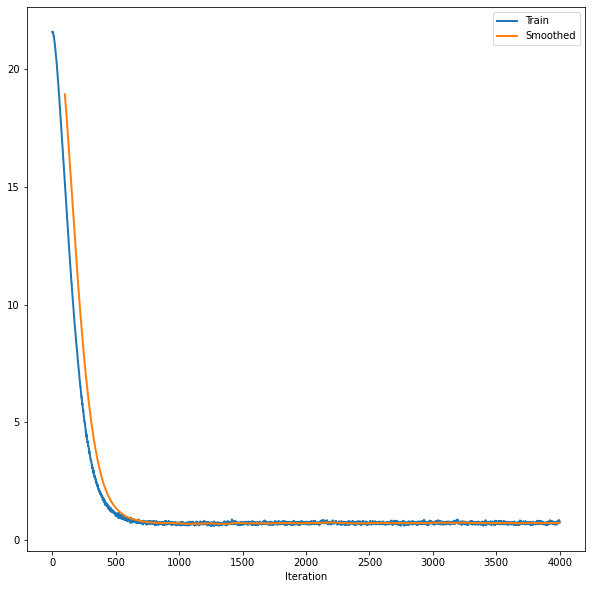

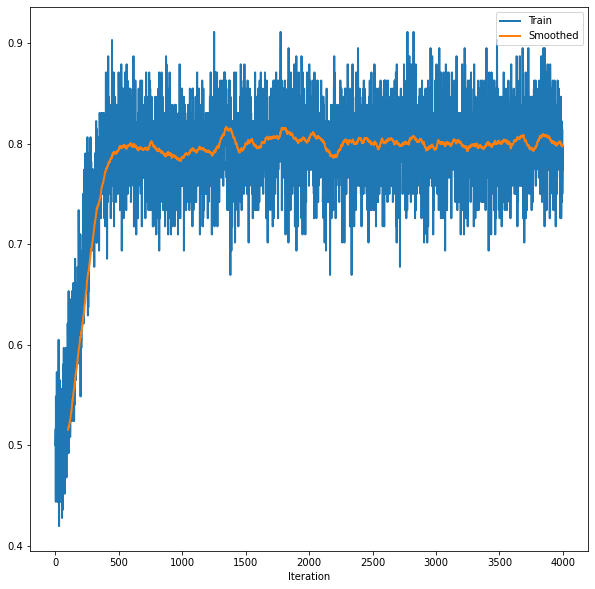

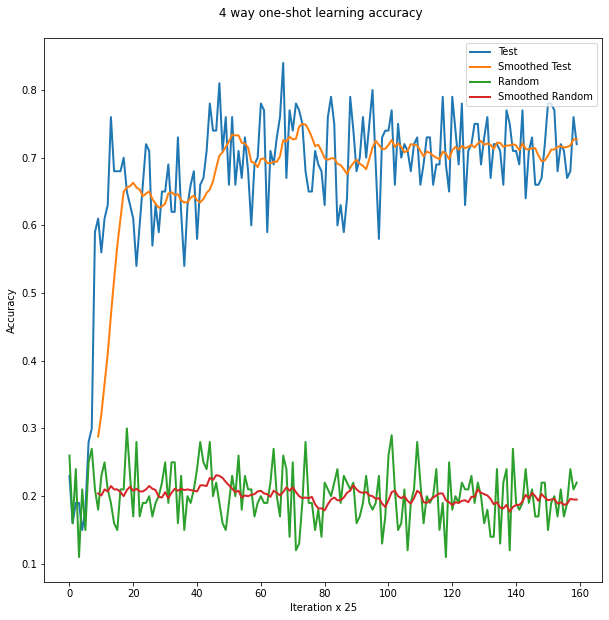

In [36]:
# Ploting loss for train and acurracy for both train and test
for data in [losses, train_accuracies]:
    plt.figure(figsize=(10,10))
    plt.plot(data, linewidth=2, label='Train')
    smoothed_data = pd.Series.rolling(pd.Series(data), 100).mean()
    plt.plot(smoothed_data, linewidth=2, label='Smoothed')
    #plt.plot(model_history['val_'+data], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    #plt.title('Model '+ data)
    #plt.ylabel(data)
    plt.xlabel('Iteration')
    plt.show()

plt.figure(figsize=(10,10))
plt.plot(test_accuracies, linewidth=2, label='Test')
smoothed_data = pd.Series.rolling(pd.Series(test_accuracies), 10).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed Test')
plt.plot(random_test_accuraccies, linewidth=2, label='Random')
smoothed_data = pd.Series.rolling(pd.Series(random_test_accuraccies), 10).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed Random')
plt.legend(loc='upper right')
plt.title("{} way one-shot learning accuracy \n".format(k_way))
plt.ylabel('Accuracy')
plt.xlabel('Iteration x {}'.format(evaluate_every_n_batches))
plt.show()

## Test Models (k-way learning)

In [37]:
!ls drive/My\ Drive/DLAS

best_model	       Data_samples.zip  v2	  v6_mfcc
Data_pairs_4khz.zip    DLAS_Report.gdoc  v3	  v7_mfcc
Data_pairs_mfcc.zip    final_model	 v4	  v8_vggish
Data_pairs_vggish.zip  v10_vggish	 v5_mfcc  v9_vggish


In [38]:
model_best_val = load_model('/content/drive/My Drive/DLAS/best_model/')
radam = tfa.optimizers.RectifiedAdam()
biCrossentropy = BinaryCrossentropy(label_smoothing=0.1)
model_best_val.compile(optimizer=radam,
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [39]:
model_last = load_model('/content/drive/My Drive/DLAS/final_model/')
radam = tfa.optimizers.RectifiedAdam()
biCrossentropy = BinaryCrossentropy(label_smoothing=0.1)
model_last.compile(optimizer=radam,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

test 2-way: 0.91 ~ 0.88
test 3-way: 0.82 ~ 0.78
test 4-way: 0.77 ~ 0.79
test 5-way: 0.66 ~ 0.71
test 6-way: 0.68 ~ 0.66
test 7-way: 0.53 ~ 0.58
test 8-way: 0.46 ~ 0.61
test 9-way: 0.5 ~ 0.47
test 10-way: 0.48 ~ 0.47
test 11-way: 0.44 ~ 0.54
test 12-way: 0.39 ~ 0.44
test 13-way: 0.47 ~ 0.49
test 14-way: 0.41 ~ 0.45
test 15-way: 0.37 ~ 0.46
test 16-way: 0.31 ~ 0.37
test 17-way: 0.41 ~ 0.37
test 18-way: 0.31 ~ 0.36
test 19-way: 0.46 ~ 0.47
test 20-way: 0.32 ~ 0.34
test 21-way: 0.35 ~ 0.35
test 22-way: 0.34 ~ 0.49
test 23-way: 0.3 ~ 0.41
test 24-way: 0.32 ~ 0.37
test 25-way: 0.37 ~ 0.36
test 26-way: 0.31 ~ 0.3
test 27-way: 0.34 ~ 0.26
test 28-way: 0.38 ~ 0.31
test 29-way: 0.3 ~ 0.32
test 30-way: 0.31 ~ 0.3
test 31-way: 0.36 ~ 0.29
test 32-way: 0.32 ~ 0.27
test 33-way: 0.19 ~ 0.33
test 34-way: 0.27 ~ 0.28
test 35-way: 0.31 ~ 0.32
test 36-way: 0.28 ~ 0.23
test 37-way: 0.23 ~ 0.33
test 38-way: 0.32 ~ 0.16
test 39-way: 0.27 ~ 0.24


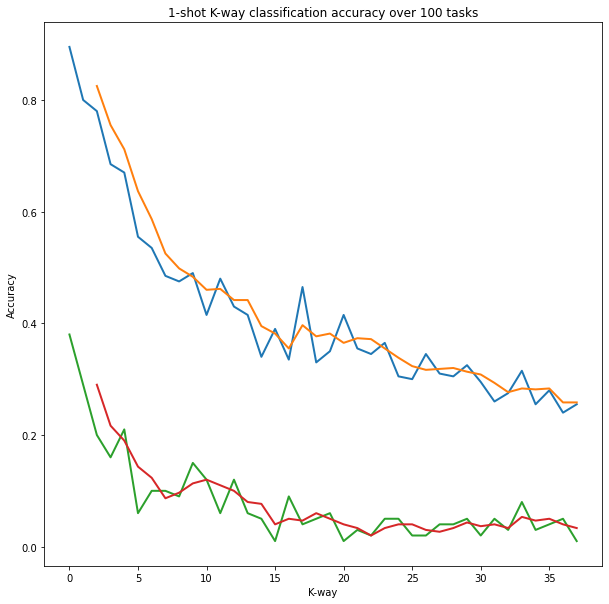

In [53]:
# Test best model
test_k_way_acc = []
random_k_way_acc = []
for k in range(2,len(labels)):
  test_k_way, random_test_k_way = test_oneshot(X=X_test, y=y_test, n_shot=n_shot, k_way=k, model=model_best_val, alike_pairs=test_alike_pairs, diff_pairs=test_diff_pairs, num_ev_tasks=num_evaluation_tasks)
  test_k_way_2, random_test_k_way = test_oneshot(X=X_test, y=y_test, n_shot=n_shot, k_way=k, model=model_best_val, alike_pairs=test_alike_pairs, diff_pairs=test_diff_pairs, num_ev_tasks=num_evaluation_tasks)
  print(f'test {k}-way: {test_k_way} ~ {test_k_way_2}')
  test_k_way_def = (test_k_way+test_k_way_2)/2
  test_k_way_acc.append(test_k_way_def)
  random_k_way_acc.append(random_test_k_way)

# Visualize test of best model
plt.figure(figsize=(10,10))
plt.plot(test_k_way_acc, linewidth=2, label='Siamese_model')
smoothed_data = pd.Series.rolling(pd.Series(test_k_way_acc), 3).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed')
plt.plot(random_k_way_acc, linewidth=2, label='Random_baseline')
smoothed_data = pd.Series.rolling(pd.Series(random_k_way_acc), 3).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed')
plt.title(f'1-shot K-way classification accuracy over {num_evaluation_tasks} tasks')
plt.ylabel('Accuracy')
plt.xlabel('K-way')
plt.show()

test 2-way: 0.9 ~ 0.89
test 3-way: 0.79 ~ 0.81
test 4-way: 0.71 ~ 0.76
test 5-way: 0.68 ~ 0.76
test 6-way: 0.59 ~ 0.62
test 7-way: 0.58 ~ 0.56
test 8-way: 0.6 ~ 0.5
test 9-way: 0.54 ~ 0.51
test 10-way: 0.5 ~ 0.49
test 11-way: 0.56 ~ 0.45
test 12-way: 0.48 ~ 0.51
test 13-way: 0.5 ~ 0.37
test 14-way: 0.42 ~ 0.47
test 15-way: 0.45 ~ 0.46
test 16-way: 0.46 ~ 0.44
test 17-way: 0.43 ~ 0.45
test 18-way: 0.39 ~ 0.42
test 19-way: 0.37 ~ 0.37
test 20-way: 0.35 ~ 0.36
test 21-way: 0.41 ~ 0.36
test 22-way: 0.41 ~ 0.47
test 23-way: 0.33 ~ 0.36
test 24-way: 0.36 ~ 0.33
test 25-way: 0.4 ~ 0.39
test 26-way: 0.32 ~ 0.29
test 27-way: 0.32 ~ 0.32
test 28-way: 0.37 ~ 0.35
test 29-way: 0.35 ~ 0.27
test 30-way: 0.35 ~ 0.3
test 31-way: 0.38 ~ 0.26
test 32-way: 0.29 ~ 0.29
test 33-way: 0.35 ~ 0.23
test 34-way: 0.3 ~ 0.31
test 35-way: 0.29 ~ 0.33
test 36-way: 0.2 ~ 0.25
test 37-way: 0.22 ~ 0.31
test 38-way: 0.34 ~ 0.3
test 39-way: 0.24 ~ 0.31


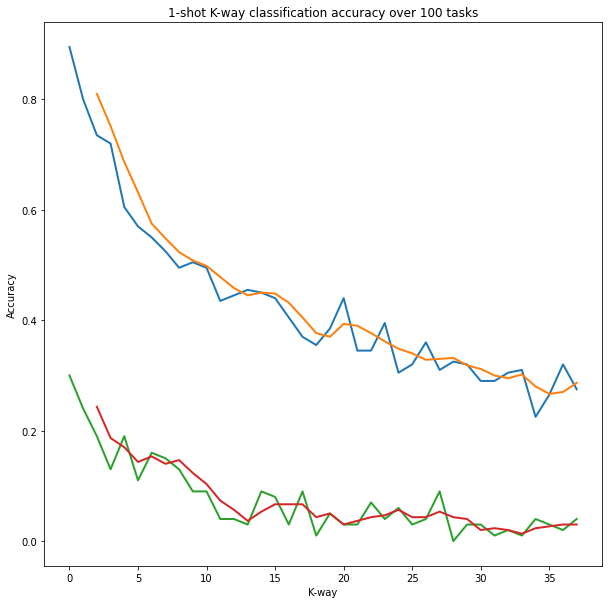

In [41]:
# Test last model
test_k_way_acc = []
random_k_way_acc = []
for k in range(2,len(labels)):
  test_k_way, random_test_k_way = test_oneshot(X=X_test, y=y_test, n_shot=n_shot, k_way=k, model=model_last, alike_pairs=test_alike_pairs, diff_pairs=test_diff_pairs, num_ev_tasks=num_evaluation_tasks)
  test_k_way_2, random_test_k_way = test_oneshot(X=X_test, y=y_test, n_shot=n_shot, k_way=k, model=model_last, alike_pairs=test_alike_pairs, diff_pairs=test_diff_pairs, num_ev_tasks=num_evaluation_tasks)
  print(f'test {k}-way: {test_k_way} ~ {test_k_way_2}')
  test_k_way_def = (test_k_way+test_k_way_2)/2
  test_k_way_acc.append(test_k_way_def)
  random_k_way_acc.append(random_test_k_way)

# Visualize test of last model
plt.figure(figsize=(10,10))
plt.plot(test_k_way_acc, linewidth=2, label='Siamese_model')
smoothed_data = pd.Series.rolling(pd.Series(test_k_way_acc), 3).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed')
plt.plot(random_k_way_acc, linewidth=2, label='Random_baseline')
smoothed_data = pd.Series.rolling(pd.Series(random_k_way_acc), 3).mean()
plt.plot(smoothed_data, linewidth=2, label='Smoothed')
plt.title(f'1-shot K-way classification accuracy over {num_evaluation_tasks} tasks')
plt.ylabel('Accuracy')
plt.xlabel('K-way')
plt.show()

## Embedding Space Visualization

In [0]:
# Extract encoder network
encoder = model_best_val.layers[2]

#Compile model
radam = tfa.optimizers.RectifiedAdam()
biCrossentropy = BinaryCrossentropy(label_smoothing=0.1)
encoder.compile(optimizer=radam,
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [0]:
n_speakers = 10
k_samples = 10

In [82]:
#Get Data
X_samples = []
y_labels = []

speakers_labels = random.sample(list(labels_train), k=n_speakers)

for label in speakers_labels:
  # get indexes of y_train with same label aka. same speaker
  index_same_speaker = [index for index in range(len(y_train)) if y_train[index]==label]
  # get random samples indexes of speaker
  rnd_samples_indexes = random.sample(index_same_speaker, k=k_samples)
  X_sample = X_train[rnd_samples_indexes]
  X_samples.extend(X_sample)
  # Add k_samples times the label value to y_labels
  y_labels += k_samples * [label]

X_samples = np.array(X_samples)
y_labels = np.array(y_labels)

print(f'X_samples shape {X_samples.shape}')
print(f'y_labels shape {y_labels.shape}')

X_samples shape (100, 21, 128, 1)
y_labels shape (100,)


In [83]:
# Get Embeddings
embeddings = encoder.predict(X_samples)
print(f'embedings shape {embeddings.shape}')

embedings shape (100, 1500)


In [86]:
# Dimensionality Reduction
tsne = TSNE()

tsne_embeddings = tsne.fit_transform(embeddings)
print(f't-SNE embedings shape {tsne_embeddings.shape}')

t-SNE embedings shape (100, 2)


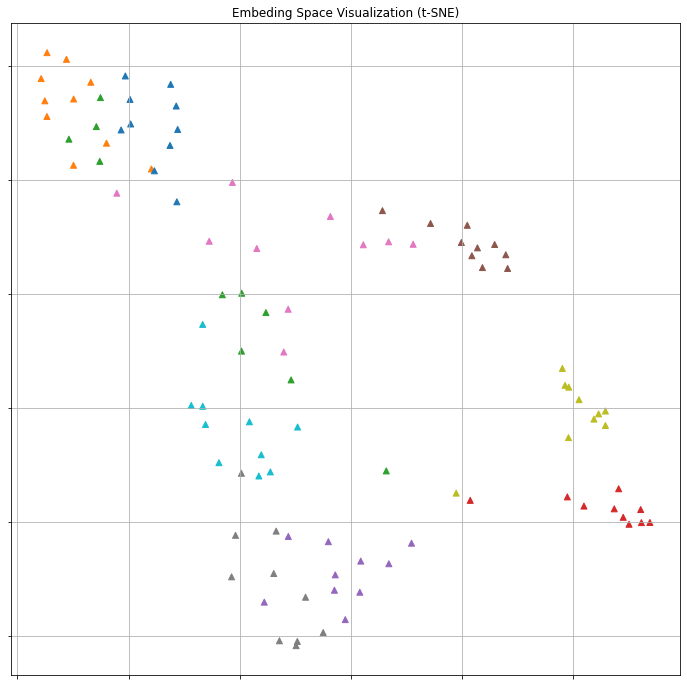

In [87]:
Z = np.hstack([tsne_embeddings, y_labels[:, np.newaxis]])

plt.figure(figsize=(12,12))
ax = plt.axes()
ax.scatter(Z[:, 0], Z[:, 1], c=[np.unique(Z[:, 2]).tolist().index(i) for i in Z[:, 2]], 
           marker='^', cmap='tab10')
ax.axes.set_xticklabels([])
ax.axes.set_yticklabels([])
plt.title('Embeding Space Visualization (t-SNE)')
plt.grid()
plt.show()